# Описание проекта
* Компания: «Цифра»
* Отрасль: золотодобывающая


**Описание данных**
* Данные содержат **параметры добычи и очистки**
* Наименование признаков должно быть такое: **[этап].[тип_параметра].[название_параметра]** (например, **rougher.input.feed_ag**)
* Возможные значения для блока **[этап]**:
    - rougher — флотация
    - primary_cleaner — первичная очистка
    - secondary_cleaner — вторичная очистка
    - final — финальные характеристики
* Возможные значения для блока **[тип_параметра]**:
    - input — параметры сырья
    - output — параметры продукта
    - state — параметры, характеризующие текущее состояние этапа
    - calculation — расчётные характеристики


**Цель исследовани**: подготовить прототип модели машинного обучения для «Цифры». Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.


**Задачи исследования**:
* Выгрузить данные
* Изучить данные:
    - Проверить, что эффективность обогащения рассчитана правильно:
        - Вычислить её на обучающей выборке для признака `rougher.output.recovery`.
        - Найти MAE между вашими расчётами и значением признака на обучающей выборке.
        - Сделать краткий вывод.
* Выявить возможные проблемы в данных:
    - Наличие пропусков
    - Наличие дубликатов
    - Наличие выбросов
    - Прочие
* Осуществить предобработку данных (устранить выявленные проблемы, выявленные при выполнении предыдущей задачи)
* Проанализировать данные:
    - Посмотреть, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Сделать вывод.
    - Сравнить распределения размеров гранул сырья на обучающей и тестовой выборках (если распределения сильно отличаются друг от друга, оценка модели будет неправильной).
    - Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.
    - При наличии аномальных значений в распределениях устранить их.
* Построение моделей машинного обучения:
    - Создать функцию для вычисления метрики sMAPE
    - Обучиить разные модели и оцените их качество кросс-валидацией:
        - Модель для целевого признака **`rougher.output.recovery`** по логике технологического процесса **необходимо оценивать по характеристикам, соответствующим этапу флотации**. Коэффициент восстановления золота на этапе флотации не может зависеть от последущих этапов (первичной и вторичной очисток). **Поэтому данные, характеризующие последущие этапы обработки нас не будут интересовать.**
        - Модель для целевого признака **`final.output.recovery`** по логике технологического процесса **необходимо оценивать по  характеристикам всех этапов обогащения**. **Коэффициент восстановления золота в конце технологическго процесса зависит от характеристик сырья, концентратов на всех предшедствующих этапах.**
        - Выбрать наилучшую модель.

# Подготовка данных

In [32]:
import pandas as pd
import numpy as np
from scipy import stats as st

from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor


import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")


## Загрузка данных

In [33]:
try:
    train = pd.read_csv('gold_recovery_train_new.csv', 
                        index_col='date', 
                        parse_dates=['date'])
    
    test = pd.read_csv('gold_recovery_test_new.csv',
                       index_col='date', 
                       parse_dates=['date'])
    
    full = pd.read_csv('gold_recovery_full_new.csv', 
                       index_col='date', 
                       parse_dates=['date'])
except:
    train = pd.read_csv('/datasets/gold_recovery_train_new.csv',
                        index_col='date', 
                        parse_dates=['date'])
    
    test = pd.read_csv('/datasets/gold_recovery_test_new.csv',
                       index_col='date', 
                       parse_dates=['date'])
    
    full = pd.read_csv('/datasets/gold_recovery_full_new.csv',
                       index_col='date', 
                       parse_dates=['date'])

In [34]:
display(train.head(3))
display(test.head(3))
display(full.head(3))

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363


## Общая информация о данных

In [35]:
# Создаем функцию для сбора описательной статистики и выявления проблем с данными
def data_description(data, description_table_show = False):
# Создаем таблицу для сохранения данных
    description_table = pd.DataFrame(index = data.columns)
# Группируем характеристики по типам данных    
    object_columns = data.dtypes[(data.dtypes == 'object')].index.tolist()
    float_int_columns = data.columns.drop(object_columns)
# Общие сведения о таблице    
    print(f'Размер таблицы {data.shape}')
    print()
    print(f'Пропущенные значения: {data.isna().sum().sum()} штук ({data.isna().sum().sum()/data.count().sum():.2%})')
    print(f'Доля наблюдений с пропусками: {((data.isna().sum(axis = 1))>0).sum()/len(data):.2%}')
    print()
    print(f'Явные дубликаты: {data.duplicated().sum()} штук ({data.duplicated().sum():.2%})')
# Заполняем таблицу с описательными данными
    description_table['type'] = data.dtypes # Тип данных столбца
    description_table['gaps_count'] = data.isna().sum() # Число пропусков в столбце
    description_table['gaps_share'] = data.isna().sum()/len(data) # Доля этих пропусков в столбце
    
    # Описательные статистики числовых данных
    description_table = description_table.join(data.loc[:,  float_int_columns].describe().T) 
    
    # Выявление неявных дубликатов в файлах с текстовой информацией
    for object_column in object_columns:
        description_table.loc[object_column, 'implicit_dups'] = data[object_column].str.lower().duplicated().sum()
   
    if description_table_show == True:    
        return description_table

In [36]:
data_description(train, True).sort_values(by = 'gaps_count', ascending = False)

Размер таблицы (14149, 86)

Пропущенные значения: 4100 штук (0.34%)
Доля наблюдений с пропусками: 22.14%

Явные дубликаты: 0 штук (0.00%)


,type,gaps_count,gaps_share,count,mean,std,min,25%,50%,75%,max
secondary_cleaner.output.tail_sol,float64,1605,0.113436,12544.0,6.938693,4.155487,0.000000,3.225486,7.302639,10.547068,17.976171
rougher.state.floatbank10_e_air,float64,436,0.030815,13713.0,1090.213187,184.610118,-1.970275,997.183864,1050.496363,1200.047746,1922.636637
rougher.input.floatbank11_xanthate,float64,428,0.030249,13721.0,5.894176,1.124233,0.000290,5.199168,5.998460,6.699006,9.698407
primary_cleaner.output.concentrate_sol,float64,286,0.020213,13863.0,10.114745,4.064076,0.000000,7.488139,9.726566,13.052807,22.280845
secondary_cleaner.state.floatbank2_a_air,float64,217,0.015337,13932.0,29.613649,5.800494,0.077503,25.099584,30.027721,34.893057,52.651399
...,...,...,...,...,...,...,...,...,...,...,...
rougher.state.floatbank10_d_air,float64,0,0.000000,14149.0,1210.335236,210.431555,-0.554299,1059.708509,1200.744308,1344.378462,1817.199290
rougher.output.concentrate_au,float64,0,0.000000,14149.0,19.439958,3.765192,0.000000,18.432161,19.947312,21.392714,28.146838
rougher.output.recovery,float64,0,0.000000,14149.0,82.704502,14.479156,0.000000,79.993067,85.299462,90.165021,100.000000
rougher.output.tail_pb,float64,0,0.000000,14149.0,0.653277,0.263766,0.007566,0.474047,0.625805,0.794326,3.778064


In [37]:
data_description(test, True).sort_values(by = 'gaps_count', ascending = False).head(13)

Размер таблицы (5290, 52)

Пропущенные значения: 90 штук (0.03%)
Доля наблюдений с пропусками: 1.15%

Явные дубликаты: 0 штук (0.00%)


,type,gaps_count,gaps_share,count,mean,std,min,25%,50%,75%,max
rougher.input.floatbank11_xanthate,float64,25,0.004726,5265.0,6.512103,0.886989,0.006985,5.999157,6.498744,7.091808,8.621338
rougher.input.feed_sol,float64,21,0.003970,5269.0,37.716648,5.491415,1.393488,34.505576,37.980276,41.635385,53.477742
secondary_cleaner.state.floatbank3_a_air,float64,9,0.001701,5281.0,25.402926,6.526457,0.000000,22.982288,25.010105,30.002063,40.041997
rougher.input.floatbank11_sulfate,float64,8,0.001512,5282.0,13.922328,3.223769,0.000077,11.997200,14.004371,16.959671,24.280966
primary_cleaner.input.depressant,float64,5,0.000945,5285.0,8.683596,3.072050,0.003839,6.489555,8.052207,10.027764,40.000000
rougher.input.floatbank10_sulfate,float64,5,0.000945,5285.0,13.855759,3.350852,0.001147,11.995006,14.003126,16.974284,24.280636
primary_cleaner.input.sulfate,float64,4,0.000756,5286.0,174.839652,43.027080,2.566156,147.121401,177.828489,208.125438,265.983123
primary_cleaner.input.xanthate,float64,4,0.000756,5286.0,1.383803,0.643474,0.004984,0.907623,1.197610,1.797819,4.102454
rougher.input.feed_rate,float64,3,0.000567,5287.0,489.800620,108.036326,0.002986,407.020883,499.051440,575.307213,707.364020
secondary_cleaner.state.floatbank2_a_air,float64,3,0.000567,5287.0,26.312630,3.429852,0.205329,24.942328,26.910569,28.091885,32.138727


In [38]:
data_description(full, True).sort_values(by = 'gaps_count', ascending = False)

Размер таблицы (19439, 86)

Пропущенные значения: 4481 штук (0.27%)
Доля наблюдений с пропусками: 17.21%

Явные дубликаты: 0 штук (0.00%)


,type,gaps_count,gaps_share,count,mean,std,min,25%,50%,75%,max
secondary_cleaner.output.tail_sol,float64,1748,0.089922,17691.0,7.167247,3.916079,0.000000,3.845475,7.685827,10.411296,26.000772
rougher.input.floatbank11_xanthate,float64,453,0.023304,18986.0,6.065533,1.099118,0.000290,5.402368,6.098580,6.801233,9.698407
rougher.state.floatbank10_e_air,float64,436,0.022429,19003.0,1080.869685,172.149992,-1.982295,998.675263,1050.029461,1199.425140,1922.636637
primary_cleaner.output.concentrate_sol,float64,370,0.019034,19069.0,10.489499,3.909639,0.000000,7.893893,10.314632,13.446702,22.458114
secondary_cleaner.state.floatbank2_a_air,float64,220,0.011317,19219.0,28.705564,5.458789,0.077503,25.048462,29.099943,33.012536,52.651399
...,...,...,...,...,...,...,...,...,...,...,...
rougher.state.floatbank10_d_level,float64,0,0.000000,19439.0,-468.239912,53.921458,-648.390665,-500.386386,-499.532412,-401.638550,-76.397327
rougher.state.floatbank10_d_air,float64,0,0.000000,19439.0,1211.563299,204.019326,-0.992219,1061.051788,1201.569141,1352.880320,1817.199290
rougher.output.tail_sol,float64,0,0.000000,19439.0,18.057106,3.449218,10.014648,15.822525,18.106867,20.088151,66.117188
rougher.output.tail_au,float64,0,0.000000,19439.0,1.816391,0.680046,0.020676,1.404207,1.808170,2.211861,9.688980


In [39]:
# Количество характеристик в обучающем и тестовом наборах данных не совпадает.
# Стоит проверить эти характеритсики.
set(train)-set(test)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

**Краткие выводы по общим характеристикам данных**:

* В каждом из файлов присутсвуют пропуски в данных. С пропусками стоит поработать отдельно, поскольку доля пропущенных наблюдений в файле с обучающей выборкой составило 22.14%. 
    - Данные индексируются датой и временем получения информации (признак **`date`**). Соседние по времени параметры часто похожи, поэтому логично заполнить пропуски методом интерполяции по времени.


* Количество характеристик в обучающей и тестовой выборках не совпадает. Для построения моделей машинного обучения это недопустимо. Вероятно, это произшло из-за того, что некоторые данные стали доступны после того как тыстовая выборка была сформирована (особенность сбора данных на предприятии). 
    - Отсутсвующие в тестовом наборе данных характеристики охватывают все 4 этапа производства.
    - Кроме того, среди отсутсвующих характеристик оказались целевые параметры (**`rougher.output.recovery, final.output.recovery`**)
    - Для начала стоит попробовать дополнить недостающие характеристики тестовой выборки из полной выборки.

In [40]:
"""
Дополнение тестового набора данных

"""
# Дополнение тестового набора данных из полной выборки
# вытаскиваем из полной таблицы целевые признаки в тестовую выборку
omitted_features = list((set(train)-set(test)))
test_new = test.join(full[omitted_features], on='date')
data_description(test_new)

Размер таблицы (5290, 86)

Пропущенные значения: 381 штук (0.08%)
Доля наблюдений с пропусками: 4.03%

Явные дубликаты: 0 штук (0.00%)


In [41]:
# Нам удалось дополнить тестовый набор данных с помощью полной выборки.
# Сохраним данные в исходную переменную
test = test_new
test.head(3)

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,primary_cleaner.output.concentrate_pb,rougher.calculation.floatbank10_sulfate_to_au_feed,final.output.tail_ag,primary_cleaner.output.concentrate_au,rougher.output.concentrate_ag,rougher.calculation.floatbank11_sulfate_to_au_feed,primary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,final.output.concentrate_sol,rougher.output.concentrate_pb
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.706851,2173.703032,12.688885,28.364867,15.734654,2102.438804,11.034524,5.560988,11.990938,8.227045
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,12.587215,2812.792778,12.829171,27.174515,15.966410,2816.389235,10.994805,5.790078,12.216172,8.309476
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,12.470523,2772.139527,12.977846,27.694098,15.885583,2769.237528,10.864110,6.049673,12.313710,7.816041


In [42]:
"""
Работа с пропусками
Как было упомянуто в промежуточных выводах соседние по времени параметры часто похожи,
поэтому логично заполнить пропуски методом интерполяции по времени
"""
test = test.interpolate(method='time')
train = train.interpolate(method='time')
full = full.interpolate(method='time')

data_description(test)
print('_'*100)
data_description(train)
print('_'*100)
data_description(full)

Размер таблицы (5290, 86)

Пропущенные значения: 0 штук (0.00%)
Доля наблюдений с пропусками: 0.00%

Явные дубликаты: 0 штук (0.00%)
____________________________________________________________________________________________________
Размер таблицы (14149, 86)

Пропущенные значения: 0 штук (0.00%)
Доля наблюдений с пропусками: 0.00%

Явные дубликаты: 0 штук (0.00%)
____________________________________________________________________________________________________
Размер таблицы (19439, 86)

Пропущенные значения: 0 штук (0.00%)
Доля наблюдений с пропусками: 0.00%

Явные дубликаты: 0 штук (0.00%)


**Краткий вывод**
* Тестовый набор данных был дополнен недостающими характеристиками с помощью полной выбоки.
* Пропуски в данных были устранены методом интерполяции по времени (уместно использование в силу особенностей технологического процесса)

### Проверка расчета эффективности обогащения

In [43]:
def recovery(data, stage):
    
    c = data[stage + '.output.concentrate_au'] # доля золота в концентрате после эатапа производства (stage)
    f = data[stage + '.input.feed_au'] # доля золота в сырье/концентрате до флотации/очистки
    t = data[stage + '.output.tail_au'] # доля золота в отвальных хвостах после флотации/очистки
    
    return (c*(f-t)/(f*(c-t)))*100   

### Вычисление эффективности обогащения после флотации на обучающей выборке

#### Оценка MAE для значения признака и расчетов

In [44]:
print('Средняя абсолютная ошибка расчета эффективности обогащения на обучающей выборке составила:')
print(mean_absolute_error(train['rougher.output.recovery'], recovery(train, 'rougher')))

Средняя абсолютная ошибка расчета эффективности обогащения на обучающей выборке составила:
9.73512347450521e-15


#### Краткие выводы
* Значения расчетной и заявленной эффективностей обогащения практически идентичны (разницу можно объяснить погрешностью алгоритмов вычисления в Python)
* Возможно, в данных могут наблюдаться аномалии. Проверку на аномалии в данных и их устранение произведенм позже.

# Анализ данных

## Анализ концентраций металлов (Au, Ag, Pb) на различных этапах очистки

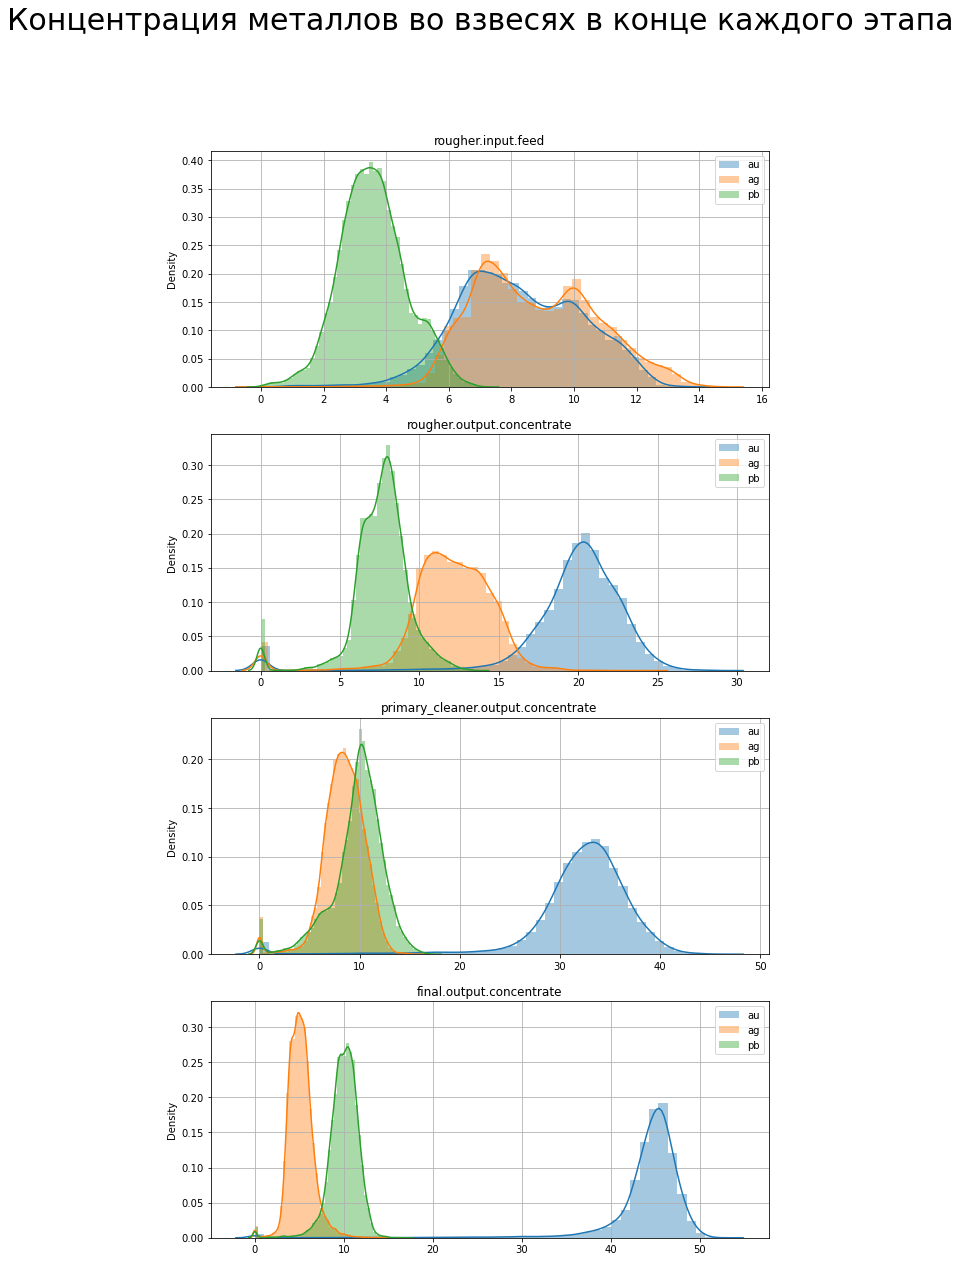

In [45]:
processing = ['rougher.input.feed',
              'rougher.output.concentrate',
              'primary_cleaner.output.concentrate',
              'final.output.concentrate']

metals = ['au', 'ag', 'pb']

fig, axs = plt.subplots(4, 1, figsize=(10, 20))
fig.suptitle('Концентрация металлов во взвесях в конце каждого этапа', fontsize=30)

for stage, ax in zip(processing, axs):
    ax.set_title(stage)
    for metal in metals:        
        cols = full.columns.str.contains(stage+'_'+metal)
        sns_ax = sns.distplot(full.loc[:, cols], label=metal, ax=ax)
    
    ax.legend(loc="upper right")
    ax.grid()
plt.show()

**Краткие выводы по распределениям**:
* В ходе технологического процесса массовая доля золота в смеси неуклонно растет.
* Как можно заметить состав первоначальной смеси имеет очень большой разброс. Это связано с непостоянным и неоптимальным физико-химическим состоянием флотационной пульпы (смеси твёрдых частиц и жидкости). В ходе очистки состав смесь стабилизируется.
* В данных присутствуют аномалии в районе нулевых значений. **Эти аномалии стот сразу удалить (оставляем все наблюдения с показателями больше 1)**.

In [46]:
processing = ['rougher.input.feed',
              'rougher.output.concentrate',
              'primary_cleaner.output.concentrate',
              'final.output.concentrate']

metals_and_sol = ['au', 'ag', 'pb']

for process in processing:
    for metal in metals:
        train_new = train[train[process+'_'+metal]>1]
        test_new = test[test[process+'_'+metal]>1]

print(f'Доля устраненных аномалий в обучающем наборе данных: {1-len(train_new)/len(train):.2%}' )
print(f'Доля устраненных аномалий в в тестовом наборе данных: {1-len(test_new)/len(test):.2%}')

train = train_new
test = test_new

Доля устраненных аномалий в обучающем наборе данных: 0.43%
Доля устраненных аномалий в в тестовом наборе данных: 0.79%


## Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках

In [47]:
def train_test_equal_means_ttest(train_data, test_data, col_name, alpha):
    
    display(pd.DataFrame([train_data[col_name].describe(), test_data[col_name].describe()], 
                         index = ['train', 'test']))
    
    results = st.ttest_ind(train_data[col_name], test_data[col_name], equal_var = False) 
    
    print('Наборы данных для поверки гипотезы о равенстве средних:')
    print('1)', 'train[' + col_name + ']')
    print('2)', 'test[' + col_name + ']')
    print()
    print('НУЛЕВАЯ ГИПОТЕЗА: средние в наборах данных равны.')
    print(f'P-значение теста на равенство средних:{results.pvalue}')
    print()
    
    if (results.pvalue > alpha):
        print('Средние указанных наборов данных статистически РАВНЫ.')
    else:
        print('Средние указанных наборов данных статистически НЕ РАВНЫ.')

In [48]:
def train_test_distplot(train_data, test_data, col_name):
    
    stage = col_name[:col_name.find('.')]
    parameter_type = col_name[col_name.find('.')+1:col_name.rfind('.')]
    parameter_name = col_name[col_name.rfind('.')+1:]
    
    ax = sns.distplot(train_data[col_name], label='train')
    ax = sns.distplot(test_data[col_name], label='test')
    plt.title(f'Распределение параметра "{parameter_name}" типа "{parameter_type}" на этапе "{stage}"', fontsize=30)
    plt.legend()
    ax.figure.set_figwidth(20)
    ax.figure.set_figheight(10)
    plt.grid()
    plt.show()

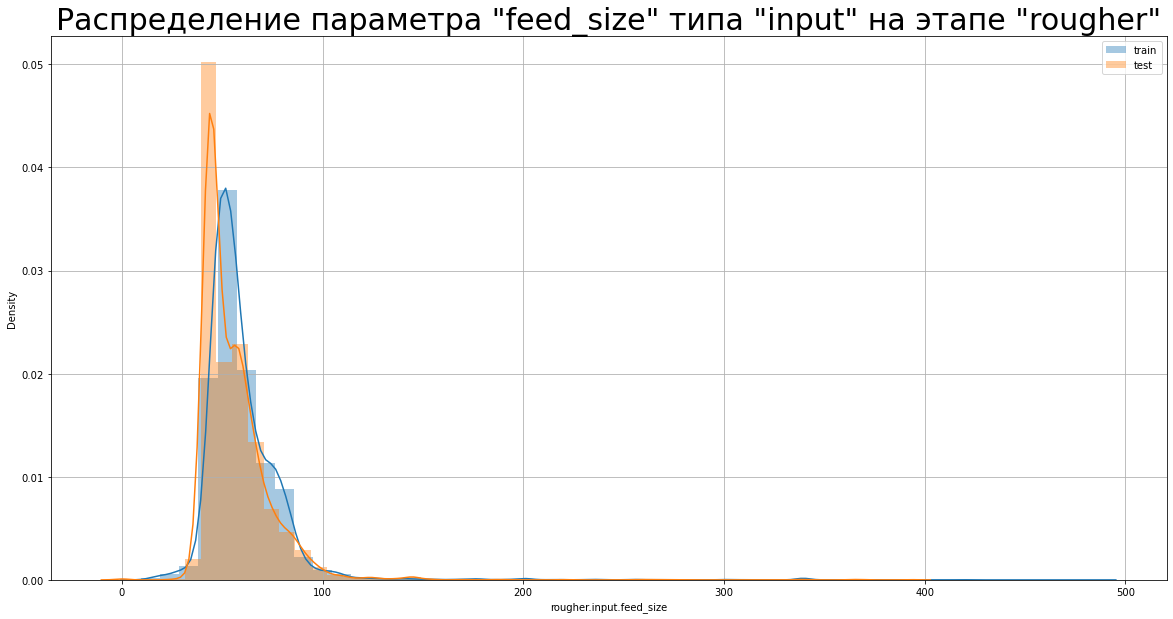

,count,mean,std,min,25%,50%,75%,max
train,14088.0,60.053760,23.099954,9.659576,48.955963,55.287253,66.009340,484.967466
test,5248.0,55.957216,19.024040,0.046369,43.911257,50.822135,62.401069,392.494040


Наборы данных для поверки гипотезы о равенстве средних:
1) train[rougher.input.feed_size]
2) test[rougher.input.feed_size]

НУЛЕВАЯ ГИПОТЕЗА: средние в наборах данных равны.
P-значение теста на равенство средних:8.517867794985416e-36

Средние указанных наборов данных статистически НЕ РАВНЫ.


In [49]:
train_test_distplot(train, test, 'rougher.input.feed_size')
train_test_equal_means_ttest(train, test, 'rougher.input.feed_size', 0.05)

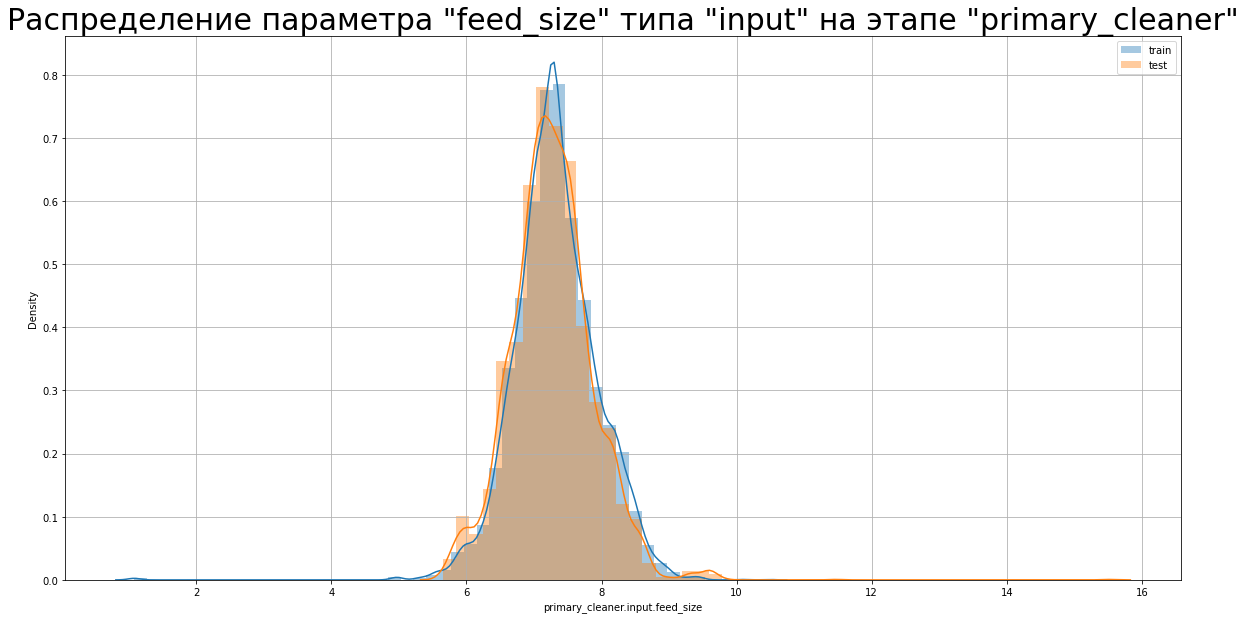

,count,mean,std,min,25%,50%,75%,max
train,14088.0,7.322465,0.613355,1.08,6.960,7.29,7.7,10.47
test,5248.0,7.267929,0.609471,5.65,6.895,7.25,7.6,15.50


Наборы данных для поверки гипотезы о равенстве средних:
1) train[primary_cleaner.input.feed_size]
2) test[primary_cleaner.input.feed_size]

НУЛЕВАЯ ГИПОТЕЗА: средние в наборах данных равны.
P-значение теста на равенство средних:3.410996769311177e-08

Средние указанных наборов данных статистически НЕ РАВНЫ.


In [50]:
train_test_distplot(train, test, 'primary_cleaner.input.feed_size')
train_test_equal_means_ttest(train, test, 'primary_cleaner.input.feed_size', 0.05)

**Краткие выводы по анализу распределения размера гранул**:
* Средние размеры гранул на этапах флотации и первичной очистки нельзя считать статистически равными. Однако на этапе первичной очистки эти распределения более. 
* Как было указано в задании, если распределения размера гранул сильно отличаются друг от друга, оценка модели будет неправильной. В нашем случае распределния идентичными считать нельзя, но и различия в распределениях не столь значительны


# Построение прототипа модели

- Модель для целевого признака **`rougher.output.recovery`** по логике технологического процесса **необходимо оценивать по характеристикам, соответствующим этапу флотации**. Коэффициент восстановления золота на этапе флотации не может зависеть от последущих этапов (первичной и вторичной очисток). **Поэтому данные, характеризующие последущие этапы обработки нас не будут интересовать.**
- Модель для целевого признака **`final.output.recovery`** по логике технологического процесса **необходимо оценивать по  характеристикам всех этапов обогащения**. **Коэффициент восстановления золота в конце технологическго процесса зависит от характеристик сырья, концентратов на всех предшедствующих этапах.**

In [58]:
# Разбиваем данные на признаки и целевые показатели

# Для модели с целевым показателем rougher.output.recovery
# оставляем только характеристики соответствующего этапа
rougher_model_columns = train.columns[train.columns.str.contains('rougher')]
# rougher_model_columns = train.columns.drop(['rougher.calculation.sulfate_to_au_concentrate',
#                                             'rougher.calculation.floatbank10_sulfate_to_au_feed',
#                                             'rougher.calculation.floatbank11_sulfate_to_au_feed',
#                                             'rougher.calculation.au_pb_ratio', 
#                                             'rougher.output.concentrate_pb', 
#                                             'rougher.output.concentrate_sol',
#                                             'rougher.output.concentrate_au', 
#                                             'rougher.output.recovery',
#                                             'rougher.output.tail_ag', 
#                                             'rougher.output.tail_pb',
#                                             'rougher.output.tail_sol', 
#                                             'rougher.output.tail_au'], axis='columns')

train_rougher = train[rougher_model_columns]
test_rougher = test[rougher_model_columns]

x_train_rougher = train_rougher.drop(['rougher.output.recovery'], axis='columns')
x_test_rougher = test_rougher.drop(['rougher.output.recovery'], axis='columns')

scaler = StandardScaler()
scaler.fit(x_train_rougher)
x_train_rougher = scaler.transform(x_train_rougher)
x_test_rougher = scaler.transform(x_test_rougher)

y_train_rougher = train_rougher['rougher.output.recovery']
y_test_rougher = test_rougher['rougher.output.recovery']

# Для модели с целевым показателем final.output.recovery
# оставляем характеристики всех этапа производства
rougher_model_columns = train.columns[(train.columns.str.contains('calculation')) &
                                     (train.columns.str.contains('output'))]

train_final = train
test_final = test

# В качестве одного из объясняющих признаков оставляем rougher.output.recovery,
# поскольку он влияет на конечный продукт
x_train_final = train_final.drop(['final.output.recovery'], axis='columns')
x_test_final = test_final.drop(['final.output.recovery'], axis='columns')

scaler = StandardScaler()
scaler.fit(x_train_final)
x_train_final = scaler.transform(x_train_final)
x_test_final = scaler.transform(x_test_final)

y_train_final = train_final['final.output.recovery']
y_test_final = test_final['final.output.recovery']

In [59]:
train_rougher.columns

Index(['rougher.calculation.sulfate_to_au_concentrate',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.au_pb_ratio', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.output.concentrate_ag',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'rougher.output.concentrate_au', 'rougher.output.recovery',
       'rougher.output.tail_ag', 'rougher.output.tail_pb',
       'rougher.output.tail_sol', 'rougher.output.tail_au',
       'rougher.state.floatbank10_a_air', 'rougher.state.floatbank10_a_level',
       'rougher.state.floatbank10_b_air', 'rougher.state.floa

## Функция вычисления итоговой sMAPE

In [60]:
# в этой ячейке сохраним сразу две функции расчёта
# smape и final smape
# smape()
def smape(y, y_pred):
    return (np.sum(2 * np.abs(y - y_pred) / (np.abs(y) + np.abs(y_pred))))/len(y)*100


smape_score = make_scorer(smape)

## Обучение моделей

### Модели для целевого показателя `rougher.output.recovery`

In [61]:
"""
Функция:
1) оценивает модели DecisionTreeRegressor с максимальной глубиной дерева из списка (depth_list)
2) оценивает для моделей метрику sMAPE для обучающей и тестовой выборок
3) осуществляет кросс-валидацию и оценивает средние значения метрик sMAPE по обучающей и тестовой выборкам 
"""
def decision_tree_regressor_models(x_train, 
                                   y_train,
                                   x_test, 
                                   y_test,
                                   depth_list,
                                   cv = 5,
                                   rnd_st = 12345):
#################################################################################################

    col_names = ['model',
                 'model_type', 
                 'depth',
                 'smape_test', 
                 'smape_test_cv_mean', 
                 'smape_train', 
                 'smape_train_cv_mean', 
                 'n_cv_splits']
    
    data = pd.DataFrame(columns = col_names)
##################################################################################################   
    for depth in depth_list:
        
        model = DecisionTreeRegressor(max_depth = depth,
                                      random_state = rnd_st)
        model = model.fit(x_train, y_train)
        
        cross_val_results = cross_validate(model, 
                                           x_train, 
                                           y_train, 
                                           scoring = smape_score, return_train_score = True)
        
        y_pred = model.predict(x_test)
        smape_test = smape(y_test, y_pred)
        
        smape_test_cv_mean = cross_val_results['test_score'].mean()
        
        y_pred = model.predict(x_train)
        smape_train = smape(y_train, y_pred)
        
        smape_train_cv_mean = cross_val_results['train_score'].mean()
        
       
    ##################################################################################################        

        row = pd.DataFrame([[model,
                             'dec_tree_reg',
                             depth,
                             smape_test,
                             smape_test_cv_mean,
                             smape_train,
                             smape_train_cv_mean, 
                             cv]], columns = col_names)
        
        data = data.append([row], ignore_index=True)
    ###############################################################################################################

    return (data.sort_values(by = 'smape_test').reset_index(drop = True).round(4))

In [62]:
%%time
rougher_dec_tree_reg_models = decision_tree_regressor_models(x_train_rougher, 
                                                             y_train_rougher, 
                                                             x_test_rougher, 
                                                             y_test_rougher, 
                                                             list(range(5,50)))

Wall time: 1min 38s


In [63]:
rougher_dec_tree_reg_models

,model,model_type,depth,smape_test,smape_test_cv_mean,smape_train,smape_train_cv_mean,n_cv_splits
0,"DecisionTreeRegressor(max_depth=14, random_sta...",dec_tree_reg,14,0.8971,1.6988,0.2222,0.2340,5
1,"DecisionTreeRegressor(max_depth=22, random_sta...",dec_tree_reg,22,0.9249,1.7163,0.0002,0.0003,5
2,"DecisionTreeRegressor(max_depth=20, random_sta...",dec_tree_reg,20,0.9252,1.7128,0.0017,0.0025,5
3,"DecisionTreeRegressor(max_depth=17, random_sta...",dec_tree_reg,17,0.9273,1.7141,0.0305,0.0371,5
4,"DecisionTreeRegressor(max_depth=19, random_sta...",dec_tree_reg,19,0.9290,1.6964,0.0048,0.0067,5
5,"DecisionTreeRegressor(max_depth=24, random_sta...",dec_tree_reg,24,0.9293,1.7230,0.0000,0.0000,5
6,"DecisionTreeRegressor(max_depth=15, random_sta...",dec_tree_reg,15,0.9351,1.6982,0.1291,0.1401,5
7,"DecisionTreeRegressor(max_depth=18, random_sta...",dec_tree_reg,18,0.9377,1.7021,0.0128,0.0165,5
8,"DecisionTreeRegressor(max_depth=13, random_sta...",dec_tree_reg,13,0.9379,1.6945,0.3454,0.3615,5
9,"DecisionTreeRegressor(max_depth=34, random_sta...",dec_tree_reg,34,0.9424,1.7161,0.0000,0.0000,5


In [64]:
"""
Функция:
1) оценивает модели RandomForestRegressor с максимальной глубиной дерева из списка (depth_list)
    и количеством деревьев из списка (estimator_list)
2) оценивает для моделей метрику sMAPE для обучающей и тестовой выборок
3) осуществляет кросс-валидацию и оценивает средние значения метрик sMAPE по обучающей и тестовой выборкам 
"""
def random_forest_regressor_models(x_train, 
                                   y_train,
                                   x_test, 
                                   y_test,
                                   depth_list,
                                   estimator_list,
                                   cv = 5,
                                   rnd_st = 12345):
#################################################################################################

    col_names = ['model',
                 'model_type', 
                 'depth',
                 'n_estimators',
                 'smape_test', 
                 'smape_test_cv_mean', 
                 'smape_train', 
                 'smape_train_cv_mean', 
                 'n_cv_splits']
    
    data = pd.DataFrame(columns = col_names)
##################################################################################################   
    for depth in depth_list:
        for est in estimator_list:
        
            model = RandomForestRegressor(max_depth = depth,
                                          n_estimators = est,
                                          random_state = rnd_st)
            model = model.fit(x_train, y_train)

            cross_val_results = cross_validate(model, 
                                               x_train, 
                                               y_train, 
                                               scoring = smape_score, return_train_score = True)

            y_pred = model.predict(x_test)
            smape_test = smape(y_test, y_pred)

            smape_test_cv_mean = cross_val_results['test_score'].mean()

            y_pred = model.predict(x_train)
            smape_train = smape(y_train, y_pred)

            smape_train_cv_mean = cross_val_results['train_score'].mean()


        ##################################################################################################        

            row = pd.DataFrame([[model,
                                 'dec_tree_reg',
                                 depth,
                                 est,
                                 smape_test,
                                 smape_test_cv_mean,
                                 smape_train,
                                 smape_train_cv_mean, 
                                 cv]], columns = col_names)

            data = data.append([row], ignore_index=True)
    ###############################################################################################################

    return (data.sort_values(by = 'smape_test').reset_index(drop = True).round(4))

In [65]:
depth_list = rougher_dec_tree_reg_models['depth'].head().tolist()
depth_list

[14, 22, 20, 17, 19]

In [66]:
%%time
rougher_dec_tree_reg_models['depth']
rougher_rand_forest_reg_models = random_forest_regressor_models(x_train_rougher, 
                                                                y_train_rougher, 
                                                                x_test_rougher, 
                                                                y_test_rougher, 
                                                                depth_list, 
                                                                [25, 50])


Wall time: 8min 31s


In [67]:
rougher_rand_forest_reg_models

,model,model_type,depth,n_estimators,smape_test,smape_test_cv_mean,smape_train,smape_train_cv_mean,n_cv_splits
0,"(DecisionTreeRegressor(max_depth=20, max_featu...",dec_tree_reg,20,50,0.5164,1.0591,0.2234,0.2527,5
1,"(DecisionTreeRegressor(max_depth=17, max_featu...",dec_tree_reg,17,50,0.5221,1.0576,0.2251,0.2565,5
2,"(DecisionTreeRegressor(max_depth=22, max_featu...",dec_tree_reg,22,50,0.5247,1.0527,0.2233,0.2543,5
3,"(DecisionTreeRegressor(max_depth=19, max_featu...",dec_tree_reg,19,50,0.5286,1.0650,0.2250,0.2528,5
4,"(DecisionTreeRegressor(max_depth=14, max_featu...",dec_tree_reg,14,50,0.5391,1.0572,0.2637,0.2955,5
5,"(DecisionTreeRegressor(max_depth=17, max_featu...",dec_tree_reg,17,25,0.5411,1.0964,0.2388,0.2763,5
6,"(DecisionTreeRegressor(max_depth=20, max_featu...",dec_tree_reg,20,25,0.5417,1.0955,0.2366,0.2736,5
7,"(DecisionTreeRegressor(max_depth=19, max_featu...",dec_tree_reg,19,25,0.5447,1.1007,0.2367,0.2733,5
8,"(DecisionTreeRegressor(max_depth=22, max_featu...",dec_tree_reg,22,25,0.5521,1.1072,0.2378,0.2740,5
9,"(DecisionTreeRegressor(max_depth=14, max_featu...",dec_tree_reg,14,25,0.5588,1.1080,0.2742,0.3136,5


In [68]:
"""
Функция:
1) оценивает модели LinearRegression
2) оценивает для моделей метрику sMAPE для обучающей и тестовой выборок
3) осуществляет кросс-валидацию и оценивает средние значения метрик sMAPE по обучающей и тестовой выборкам 
"""
def linear_models(x_train, 
                  y_train,
                  x_test, 
                  y_test,
                  cv = 5,
                  rnd_st = 12345):
#################################################################################################

    col_names = ['model',
                 'model_type', 
                 'smape_test', 
                 'smape_test_cv_mean', 
                 'smape_train', 
                 'smape_train_cv_mean', 
                 'n_cv_splits']
    
    data = pd.DataFrame(columns = col_names)
##################################################################################################   

    model = LinearRegression()

    model = model.fit(x_train, y_train)

    cross_val_results = cross_validate(model, 
                                       x_train, 
                                       y_train, 
                                       scoring = smape_score, return_train_score = True)

    y_pred = model.predict(x_test)
    smape_test = smape(y_test, y_pred)

    smape_test_cv_mean = cross_val_results['test_score'].mean()

    y_pred = model.predict(x_train)
    smape_train = smape(y_train, y_pred)

    smape_train_cv_mean = cross_val_results['train_score'].mean()


##################################################################################################        

    row = pd.DataFrame([[model,
                         'linear_reg',
                         smape_test,
                         smape_test_cv_mean,
                         smape_train,
                         smape_train_cv_mean, 
                         cv]], columns = col_names)

    data = data.append([row], ignore_index=True)
    ###############################################################################################################

    return (data.sort_values(by = 'smape_test').reset_index(drop = True).round(4))

In [69]:
%%time
rougher_linear_models = linear_models(x_train_rougher, 
                                      y_train_rougher, 
                                      x_test_rougher, 
                                      y_test_rougher)

Wall time: 511 ms


In [70]:
"""
Функция:
1) оценивает модели DummyRegressor с помощью метода из списка (strategy_list)
2) оценивает для моделей метрику sMAPE для обучающей и тестовой выборок
3) осуществляет кросс-валидацию и оценивает средние значения метрик sMAPE по обучающей и тестовой выборкам 
"""
def dummy_regressor_models(x_train, 
                           y_train, 
                           x_test, 
                           y_test,                                                   
                           strategy_list, 
                           cv=5, 
                           rnd_st=12345):
#################################################################################################

    col_names = ['model',
                 'model_type', 
                 'strategy',
                 'smape_test', 
                 'smape_test_cv_mean', 
                 'smape_train', 
                 'smape_train_cv_mean', 
                 'n_cv_splits']
    
    data = pd.DataFrame(columns = col_names)
##################################################################################################   
    for strategy in strategy_list:
        
        model = DummyRegressor(strategy = strategy)
        
        model = model.fit(x_train, y_train)
        
        cross_val_results = cross_validate(model, 
                                           x_train, 
                                           y_train, 
                                           scoring = smape_score, return_train_score = True)
        
        y_pred = model.predict(x_test)
        smape_test = smape(y_test, y_pred)
        
        smape_test_cv_mean = cross_val_results['test_score'].mean()
        
        y_pred = model.predict(x_train)
        smape_train = smape(y_train, y_pred)
        
        smape_train_cv_mean = cross_val_results['train_score'].mean()
        
       
    ##################################################################################################        

        row = pd.DataFrame([[model,
                             'dummy_reg',
                             strategy,
                             smape_test,
                             smape_test_cv_mean,
                             smape_train,
                             smape_train_cv_mean, 
                             cv]], columns = col_names)
        
        data = data.append([row], ignore_index=True)
    ###############################################################################################################

    return (data.sort_values(by = 'smape_test').reset_index(drop = True).round(4))   

In [71]:
%%time
rougher_dummy_reg_models = dummy_regressor_models(x_train_rougher, 
                                                  y_train_rougher, 
                                                  x_test_rougher, 
                                                  y_test_rougher,                                                   
                                                  ['median', 'mean'])


Wall time: 46.9 ms


In [72]:
rougher_dummy_reg_models

,model,model_type,strategy,smape_test,smape_test_cv_mean,smape_train,smape_train_cv_mean,n_cv_splits
0,DummyRegressor(strategy='median'),dummy_reg,median,8.4633,11.8566,11.3188,11.2578,5
1,DummyRegressor(),dummy_reg,mean,10.2177,12.1760,11.7825,11.7445,5


In [73]:
rougher_models = pd.concat([rougher_dec_tree_reg_models, 
                            rougher_rand_forest_reg_models, 
                            rougher_linear_models, 
                            rougher_dummy_reg_models])
rougher_models = rougher_models.sort_values(by = 'smape_test').reset_index(drop = True)
rougher_models.head()

,model,model_type,depth,smape_test,smape_test_cv_mean,smape_train,smape_train_cv_mean,n_cv_splits,n_estimators,strategy
0,"(DecisionTreeRegressor(max_depth=20, max_featu...",dec_tree_reg,20,0.5164,1.0591,0.2234,0.2527,5,50,NaN
1,"(DecisionTreeRegressor(max_depth=17, max_featu...",dec_tree_reg,17,0.5221,1.0576,0.2251,0.2565,5,50,NaN
2,"(DecisionTreeRegressor(max_depth=22, max_featu...",dec_tree_reg,22,0.5247,1.0527,0.2233,0.2543,5,50,NaN
3,"(DecisionTreeRegressor(max_depth=19, max_featu...",dec_tree_reg,19,0.5286,1.0650,0.2250,0.2528,5,50,NaN
4,"(DecisionTreeRegressor(max_depth=14, max_featu...",dec_tree_reg,14,0.5391,1.0572,0.2637,0.2955,5,50,NaN


## Обучение моделей для целевого показателя `final.output.recovery`

In [74]:
%%time
final_dec_tree_reg_models = decision_tree_regressor_models(x_train_rougher, 
                                                           y_train_rougher, 
                                                           x_test_rougher, 
                                                           y_test_rougher, 
                                                           list(range(5,50)))

final_depth_list = final_dec_tree_reg_models['depth'].head().tolist()
final_rand_forest_reg_models = random_forest_regressor_models(x_train_rougher, 
                                                              y_train_rougher, 
                                                              x_test_rougher, 
                                                              y_test_rougher, 
                                                              final_depth_list, 
                                                              [25, 50])

final_linear_models = linear_models(x_train_rougher, 
                                    y_train_rougher, 
                                    x_test_rougher, 
                                    y_test_rougher)

final_dummy_reg_models = dummy_regressor_models(x_train_rougher, 
                                                y_train_rougher, 
                                                x_test_rougher, 
                                                y_test_rougher,                                                   
                                                ['median', 'mean'])

Wall time: 10min 8s


In [75]:
final_models = pd.concat([final_dec_tree_reg_models, 
                          final_rand_forest_reg_models, 
                          final_linear_models, 
                          final_dummy_reg_models])

final_models = final_models.sort_values(by = 'smape_test').reset_index(drop = True)
final_models.head()

,model,model_type,depth,smape_test,smape_test_cv_mean,smape_train,smape_train_cv_mean,n_cv_splits,n_estimators,strategy
0,"(DecisionTreeRegressor(max_depth=20, max_featu...",dec_tree_reg,20,0.5164,1.0591,0.2234,0.2527,5,50,NaN
1,"(DecisionTreeRegressor(max_depth=17, max_featu...",dec_tree_reg,17,0.5221,1.0576,0.2251,0.2565,5,50,NaN
2,"(DecisionTreeRegressor(max_depth=22, max_featu...",dec_tree_reg,22,0.5247,1.0527,0.2233,0.2543,5,50,NaN
3,"(DecisionTreeRegressor(max_depth=19, max_featu...",dec_tree_reg,19,0.5286,1.0650,0.2250,0.2528,5,50,NaN
4,"(DecisionTreeRegressor(max_depth=14, max_featu...",dec_tree_reg,14,0.5391,1.0572,0.2637,0.2955,5,50,NaN


In [76]:
best_smape_score = 0.25*rougher_models['smape_test'].min() + 0.75*final_models['smape_test'].min()
best_smape_score_cv = 0.25*rougher_models['smape_test_cv_mean'].min() + 0.75*final_models['smape_test_cv_mean'].min()

print(f'При использовании этих наилучших моделей ИТОГОВОЕ значение метрики sMAPE составило {best_smape_score} %')
print(f'При использовании этих наилучших моделей ИТОГОВОЕ значение метрики sMAPE с КРОСС_ВАЛИДАЦИЕЙ составило {best_smape_score_cv} %')

При использовании этих наилучших моделей ИТОГОВОЕ значение метрики sMAPE составило 0.5164 %
При использовании этих наилучших моделей ИТОГОВОЕ значение метрики sMAPE с КРОСС_ВАЛИДАЦИЕЙ составило 1.0527 %


# ВЫВОДЫ

* Наилучшими моделями из рассмотренных в работе оказались модели **`RandomForestRegressor`**.
* В силу долгого процесса расчета класс моделей **`RandomForestRegressor`** был ограничен:
    - глубина деревьев ограничивалась глубиной деревьев из 5 лучших моделей типа **`DecisionTreeRegressor`**
    - количество деревьев было ограничено 2 значаниями: 25 и 50.


* Для прогнозирования целевого признака **`rougher.output.recovery`** наилучшей с точки зрения метрики **sMAPE** оказалась модель:
    - Тип модели: **`RandomForestRegressor`**
    - Глубина деревьев: **20**
    - Колтчество деревьев: **50**
* Для прогнозирования целевого признака **`rougher.output.recovery`** наилучшей с точки зрения  метрики **средней sMAPE с кросс-валидацией** оказалась модель:
    - Тип модели: **`RandomForestRegressor`**
    - Глубина деревьев: **22**
    - Колтчество деревьев: **50**


* Для прогнозирования целевого признака **`final.output.recovery`** наилучшей с точки зрения метрики **sMAPE** оказалась модель:
    - Тип модели: **`RandomForestRegressor`**
    - Глубина деревьев: **20**
    - Колтчество деревьев: **50**
* Для прогнозирования целевого признака **`final.output.recovery`** наилучшей с точки зрения метрики **средней sMAPE с кросс-валидацией** оказалась модель:
    - Тип модели: **`RandomForestRegressor`**
    - Глубина деревьев: **22**
    - Колтчество деревьев: **50**
    
* При использовании этих наилучших моделей **итоговое значение метрики sMAPE** составило **0.5164 %**
* При использовании этих наилучших моделей **итоговое значение метрики sMAPE с кросвалидацией** составило **1.0527 %**


* Обученные модели показали относительно неплохое качество прогноза со средней симметричной процентной ошибкой  0.52%-1.05%.

**ПРОЦЕСС ОПТИМИЗАЦИИ МОДЕЛИ ВОЗМОЖЕН, ОДНАКО ПОТРЕБУЕТ ЗНАЧИТЕЛЬНЫЕ ВЫЧИСЛИТЕЛЬНЫЕ МОЩНОСТИ. ОДНАКО ПРИ НАЛИЧИИ НЕОБХОДИМЫХ МОЖНОСТЕЙ В РАМКАХ ПРДЛОЖЕННОГО АЛГОРИТМА УЛУЧШЕНИЕ МОДЕЛИ ВОЗМОЖНО ПУТЕМ ДОБАВЛЕНИЯ ПАРАМЕТРОВ ДЛЯ ПЕРЕБОРА МОДЕЛЕЙ. ВСЕ ДАННЫЕ ПО МОДЕЛИРОВАНИЮ СОХРАНЕНЫ В ПЕРЕМЕННЫХ `rougher_models` и `final.output.recovery` (тип pandas.DataFrame)**
